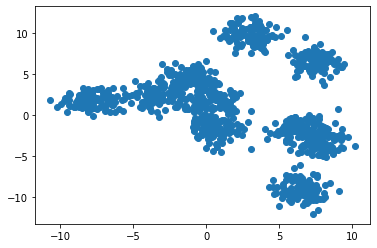

In [543]:
# 実装

# ライブラリimport
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns

# data用意
X, y = make_blobs(n_samples=1000, centers=10, cluster_std=1, n_features=2,random_state=6)

# data可視化

plt.scatter(X[:,0], X[:,1])




In [390]:
# 2. k-meansの距離関数を、ロードの差関数に変更。
# k-means自体のアルゴリズムを拡張
import itertools 

# load function
def load(num, alpha, variance):
    return alpha * num + (1-alpha) * np.linalg.norm(variance)

# load delta
def load_delta(n, alpha, node, variance, mean):
    mean_1 = (n*mean + node)/(n+1)
    var_1 = (n*(variance+np.square(mean)) + np.square(node))/(n+1) - np.square(mean_1)
    delta_var = var_1 - variance

    return alpha + (1-alpha) * np.linalg.norm(delta_var)

def kload2(data, alpha=0.5,k=4, max_iter=10,random_seed=1):
    #指定したクラスター数分のラベルを繰り返し作成するジェネレータを生成（0,1,2,0,1,2,0,1,2...みたいな感じ
    cycle = itertools.cycle(range(k))
    #各データポイントに対してクラスタのラベルをランダムに割り振る
    labels = np.fromiter(itertools.islice(cycle, data.shape[0]), dtype = int)
    random_state = np.random.RandomState(random_seed)
    random_state.shuffle(labels)
    
    labels_prev = np.zeros(data.shape[0])
    count = 0
    cluster_centers = np.zeros((k, data.shape[1]))
    variances = np.zeros((k, data.shape[1]))
    cluster_sizes = np.zeros(k)
    loads = np.zeros(k)
    
    # クラスタの変化がない、or 最大回数
    while (not np.array_equal(labels, labels_prev) and (count < max_iter)):
        # 判定用変数
        labels_prev = labels.copy()
        count += 1
        
        #その時点での各クラスターの重心を計算する

        
        for j in range(k):
            cluster_nodes = data[labels == j, :]
            cluster_sizes[j] = cluster_nodes.shape[0]
            if cluster_sizes[j] == 0:
                pass
                # variances[j, :] = 0
                # cluster_centers[j, :] = 0
            else:
                variances[j, :] = np.nanvar(cluster_nodes, axis=0)
                cluster_centers[j, :] = np.nanmean(cluster_nodes, axis = 0)
            loads[j] = load(cluster_sizes[j], alpha, variances[j])
            
        #各データポイントと各クラスターの重心間の距離を総当たりで計算する
        
        for i, x in enumerate(data):
            deltas = np.zeros(k)
            for j in range(k):
                # 1 o(1) ロードの差を計算する方法　　
                # deltas[j] = load_delta(cluster_sizes[j], alpha, x, variances[j], cluster_centers[j])
                
                # 2 loadsを再計算する方法
                # o(n/k) 計算量爆発するし、収束しない
                # cluster_nodes = data[labels == j, :]
                # cluster_size = cluster_nodes.shape[0]
                # variance = np.nanvar(cluster_nodes, axis=0)
                # deltas[j] = load(cluster_size, alpha, variance)
                
                # 3 中心点からの距離の方法
                deltas[j] = np.linalg.norm(cluster_centers[j] - x)
            # print(deltas)
            labels[i] = np.argmin(deltas)
            
        # print('cond', np.array_equal(labels, labels_prev), count<max_iter)
        # print(labels_prev[:10], labels[:10])
        # print(count)
        # print("v",variances)
        # print("num",cluster_sizes)
        # print("c", cluster_centers)
        # print("load",loads, np.sum(loads))
        # print(np.var(loads))
    # end while
    return count, cluster_sizes, loads, np.var(loads)

kload2(data=X[:1000], alpha=0.6, k=5, max_iter=50,random_seed=5)

(19,
 array([366.00, 101.00, 101.00, 301.00, 131.00]),
 array([222.25, 61.18, 61.22, 185.00, 79.84]),
 4637.929935785151)

In [391]:
# 実験
# ロードの分散を調べる。どれだけいいモデルができたか

print("\nalpha の値を変えて比較")
alphas=[0.01,0.1,0.3,0.5,0.8,0.9,0.99]
for alpha in alphas:
    print(kload2(data=X[:100], alpha=alpha, k=5, max_iter=50,random_seed=5))

print("\nデータの数を変えて比較")
nums=[10,100,500,1000]
for num in nums:
    print(kload2(data=X[:num], alpha=0.8, k=5, max_iter=50,random_seed=4))
    # %timeit kload2(data=X[:num], alpha=0.8, k=5, max_iter=50,random_seed=4)

print("\n初期のランダムネスを変えて比較")

for num in range(10):
    print(kload2(data=X[:100], alpha=0.8, k=5, max_iter=50,random_seed=num))

# 計算速度、使えるモデルができたか


alpha の値を変えて比較
(7, array([17.00, 14.00, 30.00, 18.00, 21.00]), array([2.45, 3.93, 11.08, 6.99, 2.13]), 11.265790811939308)
(7, array([17.00, 14.00, 30.00, 18.00, 21.00]), array([3.78, 4.84, 12.80, 7.99, 3.84]), 11.80784589462137)
(7, array([17.00, 14.00, 30.00, 18.00, 21.00]), array([6.71, 6.88, 16.62, 10.21, 7.65]), 13.843785349017391)
(7, array([17.00, 14.00, 30.00, 18.00, 21.00]), array([9.65, 8.91, 20.45, 12.44, 11.47]), 17.026445636505034)
(7, array([17.00, 14.00, 30.00, 18.00, 21.00]), array([14.06, 11.97, 26.18, 15.77, 17.19]), 23.950537629783295)
(7, array([17.00, 14.00, 30.00, 18.00, 21.00]), array([15.53, 12.98, 28.09, 16.89, 19.09]), 26.831928710755186)
(7, array([17.00, 14.00, 30.00, 18.00, 21.00]), array([16.85, 13.90, 29.81, 17.89, 20.81]), 29.670292261703235)

データの数を変えて比較
(2, array([3.00, 2.00, 3.00, 1.00, 1.00]), array([2.66, 2.51, 3.15, 0.80, 0.80]), 0.9763843091229063)
(6, array([18.00, 28.00, 24.00, 11.00, 19.00]), array([15.77, 24.66, 19.73, 8.97, 15.61]), 26.79408

In [555]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(formatter={'float': '{:.2f}'.format})

from sklearn.cluster import KMeans

# 各種パラメータ定義
# load function

def load(points, alpha):
    variance = np.var(points, axis=0) # o(n)
    return alpha * points.shape[0] + (1-alpha) * np.linalg.norm(variance)

def find_outmost_idx(data, center,j, labels):
    all_norms = np.linalg.norm(data - center, axis=1)
    idxs = np.array(np.where(labels == j)).flatten()
    tmp_idx = np.argmax(all_norms[idxs])
    return idxs[tmp_idx]

# k-means 1の方法
# radiusは収束半径
# 調整用最大クラスタ数 adj_k
def kload(data, alpha=0.5, k=2, radius=0.1,  max_iter=10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data)
    
    labels = np.copy(kmeans.labels_)
    inertia = kmeans.inertia_
    centers = kmeans.cluster_centers_

    iter_count = 0
    radius_prev = np.inf
    delta_prev = np.inf
    delta_load = np.inf
    while True: 
        iter_count += 1

        # クラスタ再配置 based on load func
        clusters = [ data[labels==j] for j in range(0,k)]
        loads = np.array([load(cluster, alpha) for cluster in clusters])
        # print("loads", loads)

        # ロードの計算
        max_cluster_idx = np.argmax(loads)
        min_cluster_idx = np.argmin(loads)
        max_load = loads[max_cluster_idx]
        min_load = loads[min_cluster_idx]
        
        minmax_load = max_load / min_load
        variance_load = np.linalg.norm(np.var(loads))
        
        # ロードの合計
        sum_load = loads.sum()

        delta_load = minmax_load

        if (radius_prev < radius and delta_load < delta_prev) | (max_iter < iter_count):
            break
        radius_prev = abs(delta_load - delta_prev)
        delta_prev = delta_load

        
        # 最大クラスタの大きい点を次に近いクラスタに移す。
        outmost_idx = find_outmost_idx(data, centers[max_cluster_idx],max_cluster_idx, labels)

        centers_wo_belong = np.copy(centers)
        centers_wo_belong[max_cluster_idx] = np.full(data.shape[1], np.inf)

        nearest_cluster_idx = np.argmin(np.linalg.norm(centers_wo_belong - data[outmost_idx], axis=1))
        labels[outmost_idx] = nearest_cluster_idx
        

        # print(iter_count, delta_load)
    return (iter_count, labels, loads, minmax_load, variance_load, sum_load)




In [556]:
# 素のkmeans load
def plane_kmeans(k, alpha, data):
    kmeans = KMeans(n_clusters=k,random_state=1).fit(data)
    
    labels = np.copy(kmeans.labels_)
    inertia = kmeans.inertia_
    centers = kmeans.cluster_centers_
    
    # クラスタ再配置 based on load func
    clusters = [ data[labels==j] for j in range(0,k)]
    loads = np.array([load(cluster, alpha) for cluster in clusters])
    # print("loads", loads)

    # ロードの計算
    max_cluster_idx = np.argmax(loads)
    min_cluster_idx = np.argmin(loads)
    max_load = loads[max_cluster_idx]
    min_load = loads[min_cluster_idx]

    minmax_load = max_load / min_load
    variance_load = np.linalg.norm(np.var(loads))
    
    sum_load = loads.sum()
    
    
    return (0, labels, loads, minmax_load, variance_load, sum_load)


k= 2
分類用データ 
k= 3
分類用データ 
k= 4
分類用データ 
k= 5
分類用データ 
k= 6
分類用データ 
k= 7
分類用データ 
k= 8
分類用データ 
k= 9
分類用データ 
k= 10
分類用データ 
k= 11
分類用データ 
k= 12
分類用データ 
alphaを変えた場合
alpha= 0.01
分類用データ 
(21, array([2, 2, 5, 5, 0, 5, 5, 0, 5, 5, 3, 4, 4, 3, 1, 4, 3, 1, 1, 5, 4, 3,
       0, 0, 0, 5, 4, 4, 4, 0, 5, 0, 2, 4, 4, 0, 4, 5, 4, 3, 5, 5, 4, 5,
       3, 4, 2, 1, 5, 3, 5, 1, 5, 1, 5, 4, 3, 3, 4, 5, 4, 4, 5, 5, 0, 1,
       0, 3, 5, 4, 0, 5, 4, 3, 4, 5, 3, 5, 5, 3, 1, 4, 3, 2, 1, 1, 5, 1,
       2, 0, 1, 3, 4, 1, 0, 0, 5, 3, 1, 3, 3, 3, 0, 0, 3, 2, 3, 4, 5, 4,
       1, 4, 0, 0, 3, 4, 1, 5, 2, 1, 0, 4, 1, 5, 1, 0, 0, 0, 1, 4, 3, 0,
       5, 2, 5, 3, 2, 2, 3, 1, 3, 5, 5, 1, 0, 4, 3, 2, 4, 0, 5, 5, 4, 2,
       4, 4, 5, 4, 5, 5, 5, 0, 2, 1, 3, 3, 4, 4, 5, 4, 1, 1, 1, 3, 1, 2,
       0, 5, 3, 5, 0, 5, 2, 4, 0, 5, 5, 5, 4, 4, 4, 5, 5, 1, 0, 1, 1, 4,
       5, 4, 5, 5, 5, 2, 2, 2, 1, 5, 0, 3, 3, 4, 2, 5, 5, 5, 1, 0, 1, 1,
       4, 3, 5, 5, 1, 0, 1, 4, 5, 5, 1, 0, 1, 0, 4, 0, 3, 5, 5, 4, 2, 3,
       5, 4, 2

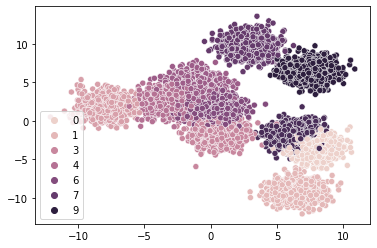

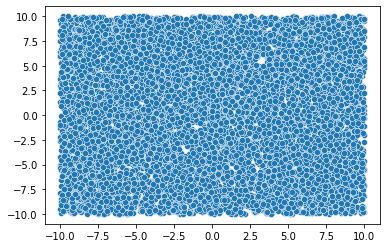

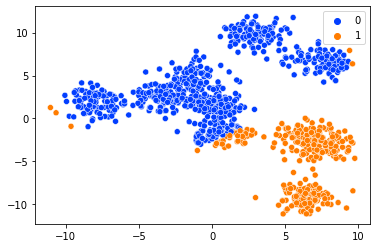

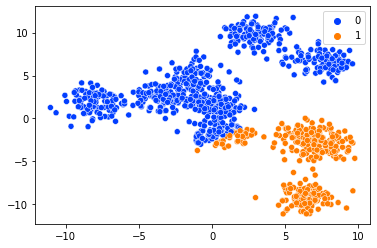

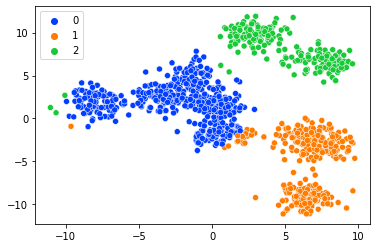

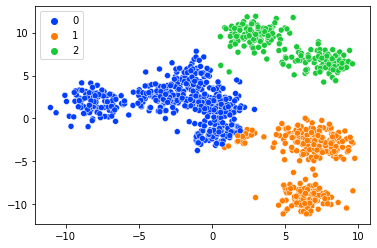

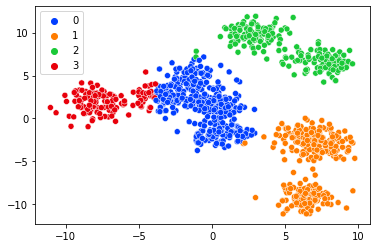

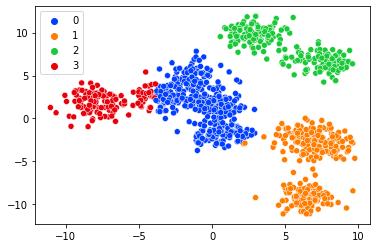

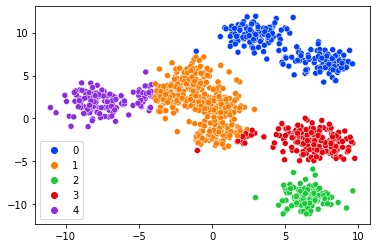

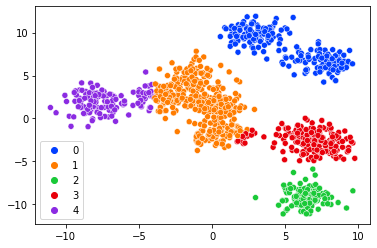

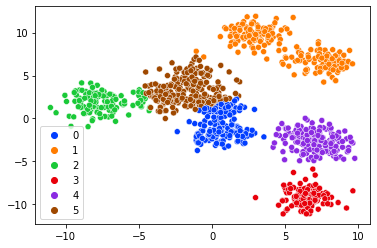

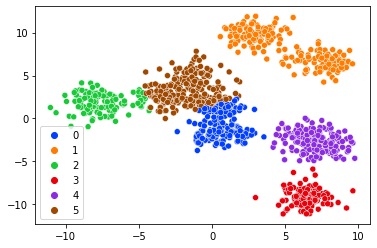

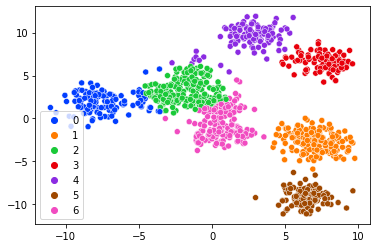

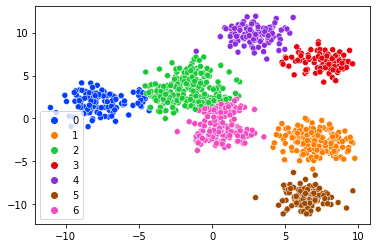

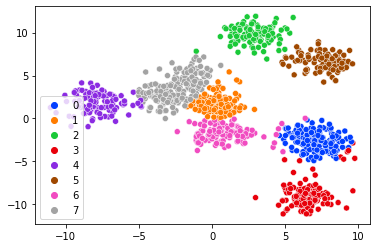

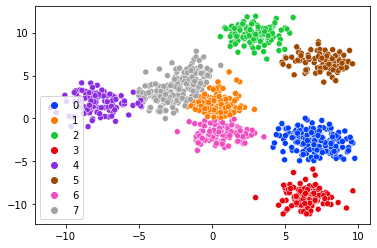

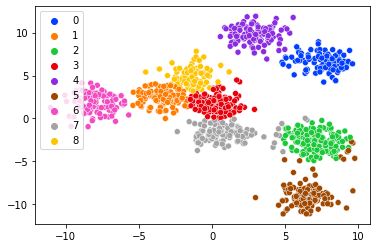

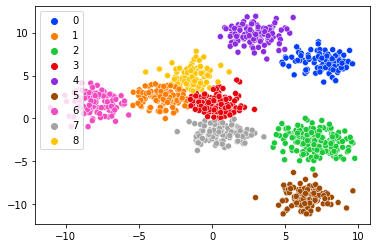

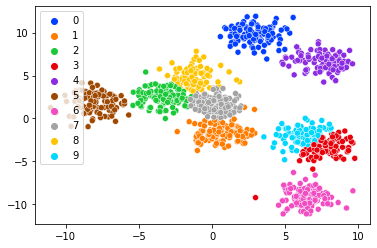

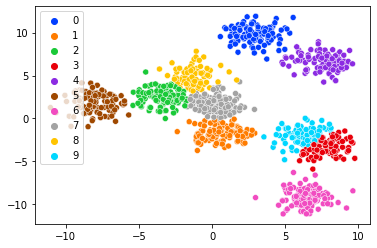

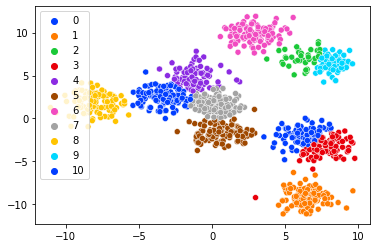

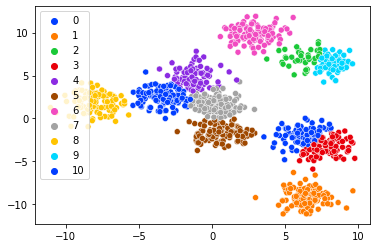

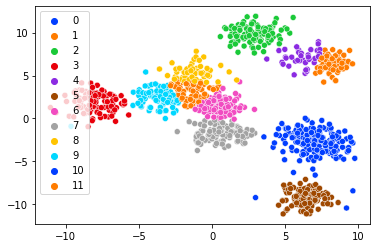

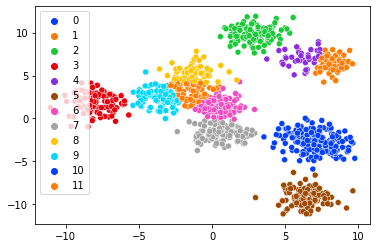

In [557]:


# 分類用 data　isotropic Gaussian blobs for clustering
X, y = make_blobs(n_samples=10000, centers=10, cluster_std=1, n_features=2,random_state=6)

plt.figure()
sns.scatterplot(x=X[:,0], y=X[:,1],hue=y)

# 一様分布 (-10, 10)
X2 = (10+10)* np.random.rand(10000,2) - 10

plt.figure()
sns.scatterplot(x=X2[:,0], y=X2[:,1])

# alpha = 0.6, n=1000
for _, k in enumerate(range(2,13)):
    
    print("k=",k)

    print("分類用データ ")

    res = kload(data=X[:1000], alpha=0.6, k=k, radius=0.01, max_iter=20 )
    plt.figure()
    sns.scatterplot(x=X[:1000,0], y=X[:1000,1], hue=res[1], palette='bright')

    res = plane_kmeans(k=k, alpha=0.6, data=X[:1000])
    plt.figure()
    sns.scatterplot(x=X[:1000,0], y=X[:1000,1], hue=res[1], palette='bright')

#     print("一様分布データ")

#     print(kload(data=X2[:1000], alpha=0.6, k=k, radius=0.01, max_iter=20 ))
#     print(plane_kmeans(k=k, alpha=0.6, data=X2[:1000]))

    
# この結果から、どちらのデータの場合も、kを変えたとしても、kloadのほうが均等に近いロードを出してる方が多い。たまに失敗している。


# alphaを変えた場合, k=6
alphas= [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]

print("alphaを変えた場合")
for _, alpha in enumerate(alphas):
    
    print("alpha=",alpha)

    print("分類用データ ")

    print(kload(data=X[:1000], alpha=alpha, k=6, radius=0.01, max_iter=20 ))
    print(plane_kmeans(k=6,alpha=alpha, data=X[:1000]))

    print("一様分布データ")

    print(kload(data=X2[:1000], alpha=alpha, k=6, radius=0.01, max_iter=20 ))
    print(plane_kmeans(k=6,alpha=alpha, data=X2[:1000]))

# alphaによってより均等になる場合がある。うまくalphaを設定する必要がある。

results = np.zeros((4,11))  
        
# print('ロードの分散')
# print(results)
        
# 評価. 可視化、ロードの分散具合、計算量、
# k, alpha, データ数, 次元数を変えてみて

# 発展
# ロード関数を変えれば、重みつきのデータにも対応。
# クラスタ入れ替え時に、一つではなくbulkでもいい

plt.show()

In [541]:


# 分類用データの中心点の数と、kを増減した時のちがい
for _, k in enumerate(range(2,13)):
    centern = 14 - k
    print("center=",centern,"k=",k)
    
    X, _ = make_blobs(n_samples=1000, centers=centern, cluster_std=1, n_features=2,random_state=6)


    print(kload(data=X[:1000], alpha=0.6, k=k, radius=0.01, max_iter=20 ))
    print(plane_kmeans(k=k, alpha=0.6, data=X[:1000]))



center= 12 k= 2
(3, array([305.02, 314.65]), 1.0315472835189534, 23.149132297297854, 619.6726380637093)
(0, array([303.54, 316.00]), 1.04104177056283, 38.79981490518995, 619.5418198857997)
center= 11 k= 3
(20, array([131.00, 291.82, 197.75]), 2.227661540200329, 4352.049788964957, 620.565823412539)
(0, array([112.92, 197.14, 303.62]), 2.6888519154545705, 6088.684383454626, 613.6733509803503)
center= 10 k= 4
(3, array([76.72, 186.82, 224.61, 122.78]), 2.9276842902056344, 3250.776254921269, 610.9206879697433)
(0, array([225.86, 185.63, 122.78, 76.72]), 2.9440339480007376, 3276.3605342525498, 610.987479217113)
center= 9 k= 5
(3, array([242.04, 137.25, 90.71, 68.46, 67.77]), 3.571720883455687, 4285.4025136755845, 606.2378585769102)
(0, array([68.46, 135.94, 90.10, 243.89, 67.77]), 3.5989525057358343, 4374.819431782884, 606.1512895168228)
center= 8 k= 6
(3, array([119.26, 80.48, 75.52, 76.18, 177.65, 75.54]), 2.3522850621853295, 1423.8489801352177, 604.650287328113)
(0, array([75.54, 178.88,

In [536]:
print('データ数による違い 速度')
nums=[20,100,500,1000, 10000]
for i, num in enumerate(nums):
    for j, k in enumerate(range(5,8)):
        print('num',num,'k', k)
        print('kload')
        %timeit -r 2 -n 10 kload(data=X[:num], alpha=0.9, k=k, radius=0.01, max_iter=100 )
        print('plane kmeans')
        %timeit -r 2 -n 10 plane_kmeans(k=k, alpha=0.9, data=X[:num])
        
        

データ数による違い 速度
num 20 k 5
kload
54.3 ms ± 5.24 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
plane kmeans
17.2 ms ± 55 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
num 20 k 6
kload
57.5 ms ± 41.9 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
plane kmeans
17.5 ms ± 152 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
num 20 k 7
kload
56.1 ms ± 160 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
plane kmeans
19.9 ms ± 1.52 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
num 100 k 5
kload
55.4 ms ± 1.22 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
plane kmeans
18.3 ms ± 894 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
num 100 k 6
kload
28.8 ms ± 5.54 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
plane kmeans
22.2 ms ± 597 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
num 100 k 7
kload
27.3 ms ± 1.72 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
plane kmeans
25.8 ms ± 83 µs per loop (mea